In [1]:
# @title Setup
from google.colab import auth
from google.cloud import bigquery
from google.colab import data_table

project = 'test-task-project-386813' # Project ID inserted based on the query results selected to explore
location = 'US' # Location inserted based on the query results selected to explore
client = bigquery.Client(project=project, location=location)
data_table.enable_dataframe_formatter()
auth.authenticate_user()

## Reference SQL syntax from the original job
Use the ```jobs.query```
[method](https://cloud.google.com/bigquery/docs/reference/rest/v2/jobs/query) to
return the SQL syntax from the job. This can be copied from the output cell
below to edit the query now or in the future. Alternatively, you can use
[this link](https://console.cloud.google.com/bigquery?j=test-task-project-386813:US:bquxjob_62e8c905_18824a5cbdb)
back to BigQuery to edit the query within the BigQuery user interface.

In [2]:
# Running this code will display the query used to generate your previous job

job = client.get_job('bquxjob_1747a794_1882e500c6c') # Job ID inserted based on the query results selected to explore
print(job.query)

SELECT
  fullVisitorId, 
  channelGrouping, 
  date, 
  visitId, visitNumber,
  device.browser, device.operatingSystem,device.deviceCategory, 
  geoNetwork.continent,geoNetwork.country, geoNetwork.city, geoNetwork.metro,
  socialEngagementType, 
  totals.bounces, totals.hits, totals.newVisits, totals.pageviews, totals.transactionRevenue,
  trafficSource.adContent, trafficSource.isTrueDirect, trafficSource.referralPath, trafficSource.source, 
  MAX(visitNumber) OVER (partition by fullVisitorId) AS visit_count_per_user,
  AVG(totals.timeOnSite) OVER (partition by fullVisitorId) AS avg_time_onsite_per_user

FROM
  `bigquery-public-data.google_analytics_sample.ga_sessions_*`
WHERE
  _TABLE_SUFFIX BETWEEN '20160801'
  AND '20170801'
ORDER BY
  date;


# Result set loaded from BigQuery job as a DataFrame
Query results are referenced from the Job ID ran from BigQuery and the query
does not need to be re-run to explore results. The ```to_dataframe```
[method](https://googleapis.dev/python/bigquery/latest/generated/google.cloud.bigquery.job.QueryJob.html#google.cloud.bigquery.job.QueryJob.to_dataframe)
downloads the results to a Pandas DataFrame by using the BigQuery Storage API.

To edit query syntax, you can do so from the BigQuery SQL editor or in the
```Optional:``` sections below.

In [3]:
# Running this code will read results from your previous job

job = client.get_job('bquxjob_1747a794_1882e500c6c') # Job ID inserted based on the query results selected to explore
results = job.to_dataframe()
results.head(3)

,fullVisitorId,channelGrouping,date,visitId,visitNumber,browser,operatingSystem,deviceCategory,continent,country,...,hits,newVisits,pageviews,transactionRevenue,adContent,isTrueDirect,referralPath,source,visit_count_per_user,avg_time_onsite_per_user
0,0064274440515862565,Organic Search,20160801,1470059347,1,Firefox,Windows,desktop,Europe,Germany,...,2,1,2,<NA>,None,<NA>,None,google,1,14.00
1,0242260641211986209,Referral,20160801,1470102520,1,Chrome,Macintosh,desktop,Americas,United States,...,3,1,3,<NA>,None,<NA>,/,(direct),1,21.00
2,0437273981466271229,Referral,20160801,1470071952,1,Chrome,Macintosh,desktop,Americas,United States,...,12,1,10,<NA>,None,<NA>,/,(direct),4,365.75


In [4]:
df = results.copy()

In [5]:
df.describe()

,visitId,visitNumber,bounces,hits,newVisits,pageviews,transactionRevenue,visit_count_per_user,avg_time_onsite_per_user
count,903653.0,903653.0,450630.0,903653.0,703060.0,903553.0,11515.0,903653.0,526409.000000
mean,1485007289.064562,2.264897,1.0,4.596538,1.0,3.849764,133744788.536691,3.265023,279.326155
std,9022123.556191,9.283735,0.0,9.641437,0.0,7.025274,448285227.299583,14.254409,406.079959
min,1470034812.0,1.0,1.0,1.0,1.0,1.0,10000.0,1.0,1.000000
25%,1477561169.0,1.0,1.0,1.0,1.0,1.0,24930000.0,1.0,46.000000
50%,1483948658.0,1.0,1.0,2.0,1.0,1.0,49450000.0,1.0,118.285714
75%,1492758762.0,1.0,1.0,4.0,1.0,4.0,107655000.0,2.0,353.500000
max,1501657193.0,395.0,1.0,500.0,1.0,469.0,23129500000.0,395.0,10046.000000


In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import gc
import sys
import math

from datetime import datetime

In [7]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

I have chosen **transactionRevenue** as a target variable.

It reflects whether the customer purchased or not. From the describe method we can see large value range for the target. So, we'll try to analyze it as logarithm.

There is a disbalance between classes in *transactionRevenue* of who transacted and who did not (missings in the target) - common problem for task of e-commerce revenue prediction.
For target NaN means that the client didn't purchase, or revenue = 0. 

In [8]:
df.transactionRevenue.fillna(0, inplace = True)

In [9]:
df.transactionRevenue = np.log1p(df.transactionRevenue.astype(float))

In [10]:
df.transactionRevenue.describe()

count    903653.000000
mean          0.227118
std           2.003710
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max          23.864375
Name: transactionRevenue, dtype: float64

That's easier to interprete and visualize.

In [11]:
non_zero = df[df["transactionRevenue"] > 0]["transactionRevenue"]

<ipython-input-13-ac1fca03ae79>:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(non_zero)


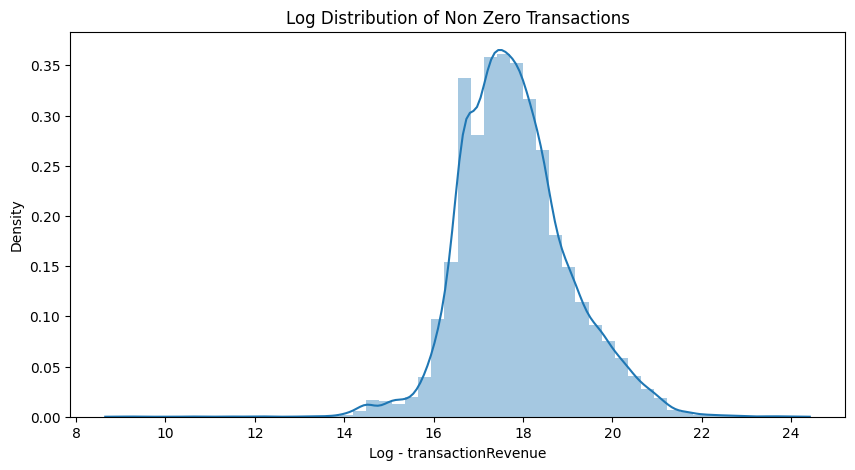

In [13]:
plt.figure(figsize = (10,5))
sns.distplot(non_zero)
plt.title("Log Distribution of Non Zero Transactions");
plt.xlabel("Log - transactionRevenue");

## EDA

In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 903653 entries, 0 to 903652
Data columns (total 24 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   fullVisitorId             903653 non-null  object 
 1   channelGrouping           903653 non-null  object 
 2   date                      903653 non-null  object 
 3   visitId                   903653 non-null  Int64  
 4   visitNumber               903653 non-null  Int64  
 5   browser                   903653 non-null  object 
 6   operatingSystem           903653 non-null  object 
 7   deviceCategory            903653 non-null  object 
 8   continent                 903653 non-null  object 
 9   country                   903653 non-null  object 
 10  city                      903653 non-null  object 
 11  metro                     903653 non-null  object 
 12  socialEngagementType      903653 non-null  object 
 13  bounces                   450630 non-null  I

Insights from **.info()**:

1.   We have to deal with 14 object variables;
2.   Several variables have big share of missings, we will work it out;


In [15]:
missing_cnt = df.isnull().sum().sort_values()
missing_cnt[missing_cnt > 0]

pageviews                      100
newVisits                   200593
avg_time_onsite_per_user    377244
bounces                     453023
referralPath                572712
isTrueDirect                629648
adContent                   892707
dtype: int64

**referralPath** and **adContent** are object features, so I'll add one more class 'unknown' for them

In [16]:
for col in ['referralPath', 'adContent']:
    df[col].fillna('unknown', inplace = True)

**pageviews** - numerical feature, according to column description reflect cnt of visited pages, so the default value will be 1;

**newVisits** - number of new users in session. If this is the first visit, the value is 1, otherwise it is nan, we'll replace it with numerical 0;

**avg_time_onsite_per_user** - generated column that provides with insights on average length of sessions on user level;

**bounces** - total bounces (for convenience). For a bounced session, the value is 1, otherwise it is nan, we'll replace it with numerical 0;

**isTrueDirect** - boolean feature, replace NaNs with False


In [17]:
df.pageviews.fillna(1, inplace = True)
df.pageviews = df.pageviews.astype(int)

df.newVisits.fillna(0, inplace = True)
df.newVisits = df.newVisits.astype(int)

df.avg_time_onsite_per_user.fillna(0, inplace = True)

df.bounces.fillna(0, inplace = True)
df.bounces = df.bounces.astype(int)

In [18]:
df.isTrueDirect.fillna(False, inplace = True)

One more point is that variables with only one unique value won't drive any impact to our model. We'll check whether we have such:

In [19]:
const_columns = [col for col in df.columns if df[col].nunique() == 1]
const_columns

['socialEngagementType']

In [20]:
# drop socialEngagementType
df.drop(const_columns, axis = 1, inplace = True)
df.head(3)

,fullVisitorId,channelGrouping,date,visitId,visitNumber,browser,operatingSystem,deviceCategory,continent,country,city,metro,bounces,hits,newVisits,pageviews,transactionRevenue,adContent,isTrueDirect,referralPath,source,visit_count_per_user,avg_time_onsite_per_user
0,0064274440515862565,Organic Search,20160801,1470059347,1,Firefox,Windows,desktop,Europe,Germany,not available in demo dataset,not available in demo dataset,0,2,1,2,0.0,unknown,False,unknown,google,1,14.00
1,0242260641211986209,Referral,20160801,1470102520,1,Chrome,Macintosh,desktop,Americas,United States,Mountain View,San Francisco-Oakland-San Jose CA,0,3,1,3,0.0,unknown,False,/,(direct),1,21.00
2,0437273981466271229,Referral,20160801,1470071952,1,Chrome,Macintosh,desktop,Americas,United States,New York,New York NY,0,12,1,10,0.0,unknown,False,/,(direct),4,365.75


**Date** column has object dtype, which has to be formatted. We'll generate several additional columns for future feature generation

In [21]:
df['formated_date'] = df['date'].apply(lambda x: datetime.strptime(str(x), '%Y%m%d'))
df['month'] = df['formated_date'].apply(lambda x: x.month)
df['weekday'] = df['formated_date'].apply(lambda x: x.weekday())
df['day'] = df['formated_date'].apply(lambda x: x.day)

df.drop(['formated_date'], axis = 1, inplace = True)

In [22]:
df.date = pd.to_datetime(df.date)

### Data Visualization

Preparing dataset only with those sessions where transactions were completed:

In [23]:
transacted_visits = df[df.transactionRevenue > 0].copy().reset_index(drop = True)
transacted_visits.head(3)

,fullVisitorId,channelGrouping,date,visitId,visitNumber,browser,operatingSystem,deviceCategory,continent,country,city,metro,bounces,hits,newVisits,pageviews,transactionRevenue,adContent,isTrueDirect,referralPath,source,visit_count_per_user,avg_time_onsite_per_user,month,weekday,day
0,1468560120795000800,Organic Search,2016-08-01,1470085227,5,Chrome,Macintosh,desktop,Americas,United States,San Francisco,San Francisco-Oakland-San Jose CA,0,22,0,17,19.195039,unknown,True,unknown,google,6,589.50,8,0,1
1,7589137567725941774,Referral,2016-08-01,1470075801,1,Chrome,Macintosh,desktop,Americas,United States,Ann Arbor,Detroit MI,0,51,1,43,16.849502,unknown,False,/,(direct),1,1060.00,8,0,1
2,7545791097611675575,Referral,2016-08-01,1470091243,11,Chrome,Macintosh,desktop,Americas,United States,San Francisco,San Francisco-Oakland-San Jose CA,0,49,0,35,18.443909,unknown,True,/,(direct),18,266.25,8,0,1


**Hits**

In [24]:
df.hits.describe()

count    903653.0
mean     4.596538
std      9.641437
min           1.0
25%           1.0
50%           2.0
75%           4.0
max         500.0
Name: hits, dtype: Float64

In [25]:
transacted_visits.hits.describe()

count      11515.0
mean     36.274251
std      30.269294
min            2.0
25%           19.0
50%           28.0
75%           44.0
max          500.0
Name: hits, dtype: Float64

From these describe methods we can see that average number of hits for all observations is much less than the average number of hits for only those sessions where transaction was completed.

This leads me to suggest that hits and transactionRevenue may correlate.



**Pageviews**

In [28]:
df.pageviews.describe()

count    903653.000000
mean          3.849449
std           7.024949
min           1.000000
25%           1.000000
50%           1.000000
75%           4.000000
max         469.000000
Name: pageviews, dtype: float64

In [29]:
transacted_visits.pageviews.describe()

count    11515.000000
mean        28.330439
std         21.727555
min          2.000000
25%         16.000000
50%         23.000000
75%         34.000000
max        469.000000
Name: pageviews, dtype: float64

pageviews numbers only for sessions with completed transactions exceed ones for all the sessions from the original dataset. There may be positive correlation between pageviews and target transactionRevenue.

**channelGrouping**

The plot reflects difference between shares of transacted sessions to the total number of sessions in the classes in two data sets: with all observations included and only with those where transactionRevenue > 0. Function for the plot:

In [30]:
def plot_var_distribution (all_visits, target_visits, variable, max_n = np.nan):

    if max_n == max_n: 
        vals = target_visits[variable].value_counts()[:max_n]
        av_2 = all_visits.loc[all_visits[variable].isin(vals.index.values), variable]
        df1 = pd.DataFrame({'All visits':av_2.value_counts() / len(all_visits), 'Transacted visits': vals / len(target_visits)})

    else:
        df1 = pd.DataFrame({'All visits':all_visits[variable].value_counts() / len(all_visits), 'Transacted visits': target_visits[variable].value_counts() / len(target_visits)})

    df1.sort_values('Transacted visits').plot.barh()

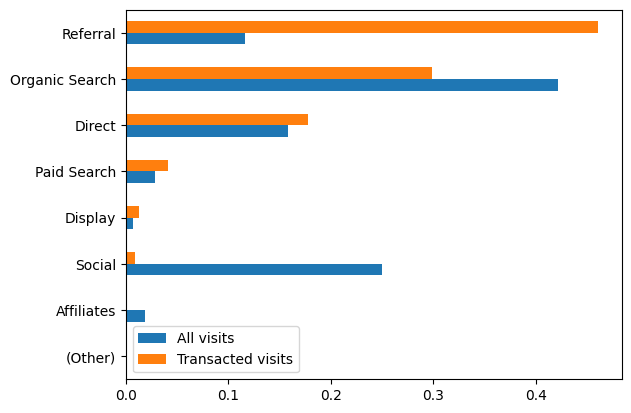

In [31]:
# channelGrouping
plot_var_distribution(df, transacted_visits, 'channelGrouping')

In [32]:
print("Channel Grouping used: ")
df.channelGrouping.value_counts()[:5]


Channel Grouping used: 


Organic Search    381561
Social            226117
Direct            143026
Referral          104838
Paid Search        25326
Name: channelGrouping, dtype: int64

So, we can see that the biggest class of this variable is Organic Search. But the biggest share of completed transactions is accounted for by *Referrals*. Interesting point!



**visitNumber** show the session number for user. The distribution is skewed right, as we can see from describe method.

It can be interpreted as following: big part of users visit platform just a few times.

In [33]:
# visitNumber
df.visitNumber.value_counts().describe()

count           384.0
mean      2353.263021
std      36227.152342
min               1.0
25%               3.0
50%               6.0
75%             26.25
max          703060.0
Name: visitNumber, dtype: Float64

**Browser**

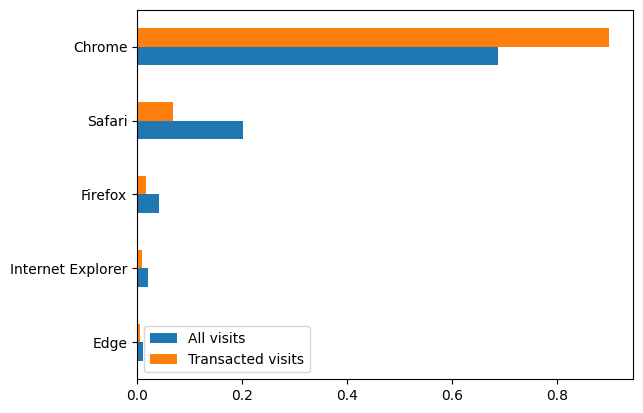

In [34]:
# browser
plot_var_distribution(df, transacted_visits, 'browser', 5)

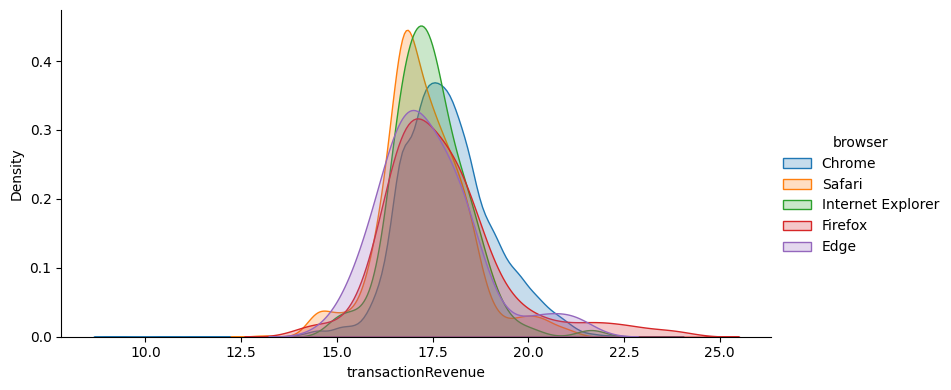

In [35]:
(sns.FacetGrid(df[(df['browser'].isin(df['browser'].value_counts()[:5].index.values)) & df['transactionRevenue'] > 0],\
               hue='browser', height = 4, aspect = 2).map(sns.kdeplot, 'transactionRevenue', fill = True).add_legend())
plt.show()

**browser** variable gives the insight that the biggest share of transaction came from Chrome browser.

**deviceCategory**

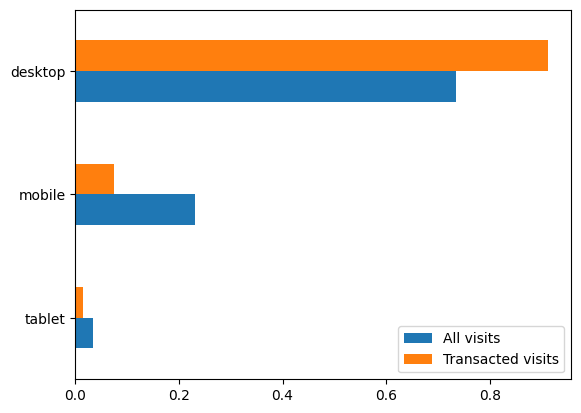

In [36]:
plot_var_distribution(df, transacted_visits, 'deviceCategory')

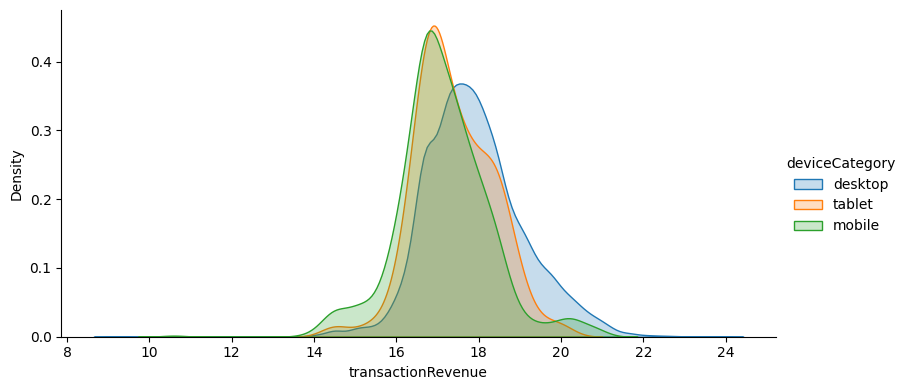

In [37]:
(sns.FacetGrid(df[(df['deviceCategory'].isin(df['deviceCategory'].value_counts()[:5].index.values)) & df['transactionRevenue'] > 0],\
               hue='deviceCategory', height = 4, aspect = 2).map(sns.kdeplot, 'transactionRevenue', fill = True).add_legend())
plt.show()

From graphs for **deviceCategory** distribution we may hypothesize that users of desktop version tend to bring more revenue than other classes of this variable

**operatingSystem**

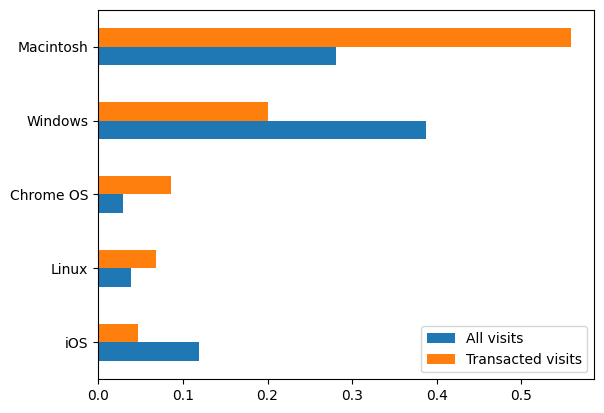

In [38]:
# operatingSystem
plot_var_distribution(df, transacted_visits, 'operatingSystem', 5)

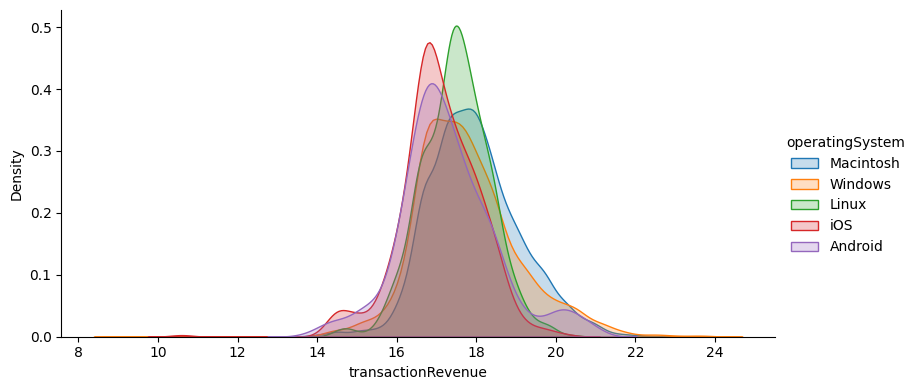

In [39]:
(sns.FacetGrid(df[(df['operatingSystem'].isin(df['operatingSystem'].value_counts()[:5].index.values)) & df['transactionRevenue'] > 0],\
               hue='operatingSystem', height = 4, aspect = 2).map(sns.kdeplot, 'transactionRevenue', fill = True).add_legend())
plt.show()

kdes for each **OS** overlap each other, so there's no significant difference between distributions of OS classes. However, it can be hypothesized that Macintosh users tend to bring more revenue than others.



## Feature generation

Let's generate some more features:

In [40]:
df['mean_hits_per_day'] = df.groupby(['day'])['hits'].transform('mean')
df['mean_hits_per_weekday'] = df.groupby(['weekday'])['hits'].transform('mean')
df['mean_hits_per_month'] = df.groupby(['month'])['hits'].transform('mean')
df['sum_hits_per_day'] = df.groupby(['day'])['hits'].transform('sum')
df['sum_hits_per_weekday'] = df.groupby(['weekday'])['hits'].transform('sum')
df['sum_hits_per_month'] = df.groupby(['month'])['hits'].transform('sum')

In [41]:
for feature in ['hits', 'pageviews']:
    grouped_data = df.groupby('fullVisitorId')[feature].mean()
    df['user_mean_' + feature] = df.fullVisitorId.map(grouped_data)
    
for feature in ['visitNumber']:
    grouped_data = df.groupby('fullVisitorId')[feature].max()
    df['user_max_' + feature] = df.fullVisitorId.map(grouped_data)

del grouped_data

In [42]:
df['source_country'] = df['source'] + '_' + df['country']
df['browser_category'] = df['browser'] + '_' + df['deviceCategory']
df['browser_os'] = df['browser'] + '_' + df['operatingSystem']

In [43]:
df.dtypes

fullVisitorId                       object
channelGrouping                     object
date                        datetime64[ns]
visitId                              Int64
visitNumber                          Int64
browser                             object
operatingSystem                     object
deviceCategory                      object
continent                           object
country                             object
city                                object
metro                               object
bounces                              int64
hits                                 Int64
newVisits                            int64
pageviews                            int64
transactionRevenue                 float64
adContent                           object
isTrueDirect                       boolean
referralPath                        object
source                              object
visit_count_per_user                 Int64
avg_time_onsite_per_user           float64
month      

To deal with object variables we'll use **pd.factorize()**

In [44]:
final_df = df.copy()

In [45]:
final_df.drop(['visitId'], axis = 1, inplace = True)

for i, t in final_df.loc[:, final_df.columns != 'fullVisitorId'].dtypes.items():
    if t == object:
        final_df[i].fillna('unknown', inplace = True)
        final_df[i] = pd.factorize(final_df[i])[0]

In [46]:
final_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 903653 entries, 0 to 903652
Data columns (total 37 columns):
 #   Column                    Non-Null Count   Dtype         
---  ------                    --------------   -----         
 0   fullVisitorId             903653 non-null  object        
 1   channelGrouping           903653 non-null  int64         
 2   date                      903653 non-null  datetime64[ns]
 3   visitNumber               903653 non-null  Int64         
 4   browser                   903653 non-null  int64         
 5   operatingSystem           903653 non-null  int64         
 6   deviceCategory            903653 non-null  int64         
 7   continent                 903653 non-null  int64         
 8   country                   903653 non-null  int64         
 9   city                      903653 non-null  int64         
 10  metro                     903653 non-null  int64         
 11  bounces                   903653 non-null  int64         
 12  hi

Fixing several issues with dtypes:

In [47]:
final_df[['mean_hits_per_day', 'mean_hits_per_weekday', 'mean_hits_per_month', 'user_mean_hits', 'visitNumber', 'hits']]\
 = final_df[['mean_hits_per_day', 'mean_hits_per_weekday', 'mean_hits_per_month', 'user_mean_hits', 'visitNumber', 'hits']].astype('float')

In [48]:
final_df[['visit_count_per_user', 'sum_hits_per_day', 'sum_hits_per_weekday', 'sum_hits_per_month', 'user_max_visitNumber']]\
 = final_df[['visit_count_per_user', 'sum_hits_per_day', 'sum_hits_per_weekday', 'sum_hits_per_month', 'user_max_visitNumber']].astype('int')

In [49]:
final_df[['isTrueDirect']] = final_df[['isTrueDirect']].astype('bool')

Let's take a glance at correlation matrix, visualized as a heatmap.

<ipython-input-50-7b642e28f448>:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  heatmap = sns.heatmap(final_df.corr(), vmin = -1, vmax = 1)


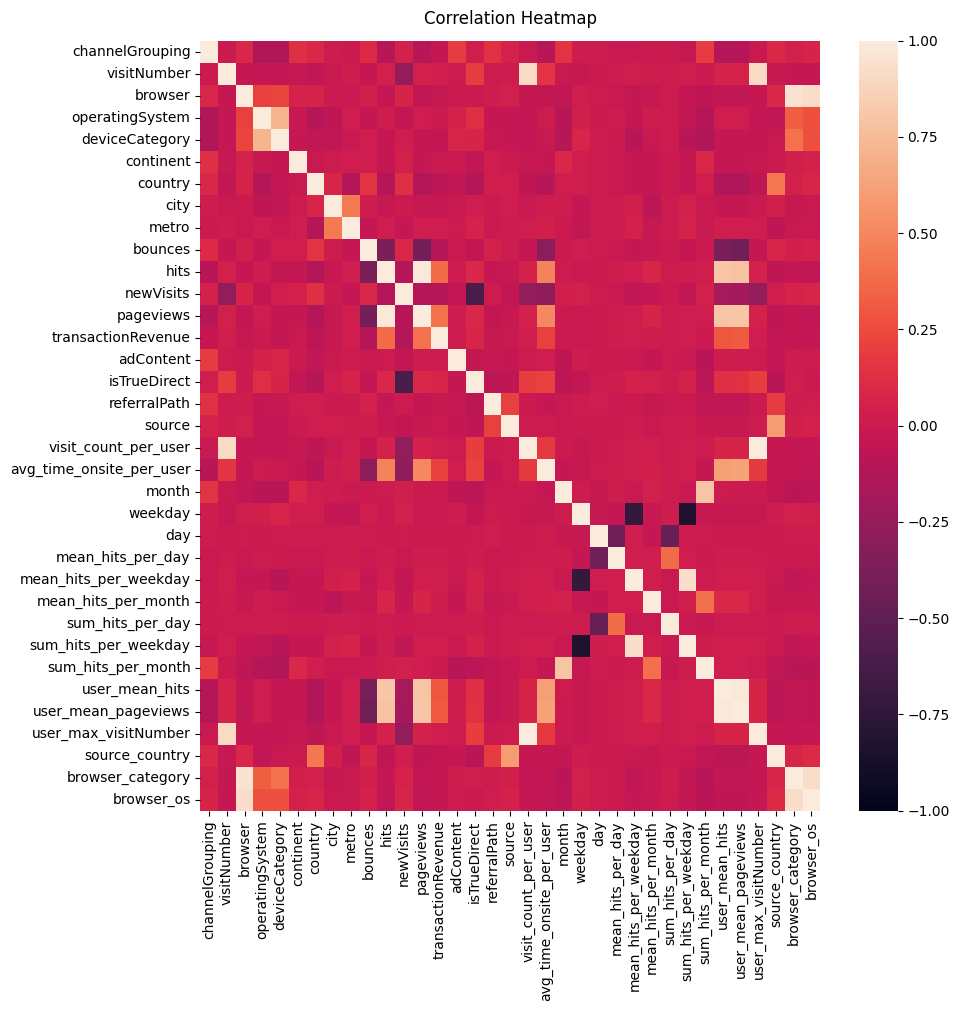

In [50]:
plt.figure(figsize = (10, 10))
heatmap = sns.heatmap(final_df.corr(), vmin = -1, vmax = 1)
heatmap.set_title('Correlation Heatmap', fontdict={'fontsize': 12}, pad = 12);

Correlation matrix is huge! Nevertheless it is possible to note that there's correlation between target and pageviews, hits about 0.50.

And the correlation between target and avg_time_onsite_per_user, user_mean_pageviews, user_mean_hits which is about 0.25. If we look at the graph again, we'll find out that these three features also correlate with each other. It is important to keep this point in mind 

In [51]:
final_df.head(3)

,fullVisitorId,channelGrouping,date,visitNumber,browser,operatingSystem,deviceCategory,continent,country,city,metro,bounces,hits,newVisits,pageviews,transactionRevenue,adContent,isTrueDirect,referralPath,source,visit_count_per_user,avg_time_onsite_per_user,month,weekday,day,mean_hits_per_day,mean_hits_per_weekday,mean_hits_per_month,sum_hits_per_day,sum_hits_per_weekday,sum_hits_per_month,user_mean_hits,user_mean_pageviews,user_max_visitNumber,source_country,browser_category,browser_os
0,0064274440515862565,0,2016-08-01,1.0,0,0,0,0,0,0,0,0,2.0,1,2,0.0,0,False,0,0,1,14.00,8,0,1,4.612934,4.698272,6.117028,149007,662010,472938,2.00,2.00,1,0,0,0
1,0242260641211986209,1,2016-08-01,1.0,1,1,0,1,1,1,1,0,3.0,1,3,0.0,0,False,1,1,1,21.00,8,0,1,4.612934,4.698272,6.117028,149007,662010,472938,3.00,3.00,1,1,1,1
2,0437273981466271229,1,2016-08-01,1.0,1,1,0,1,1,2,2,0,12.0,1,10,0.0,0,False,1,1,4,365.75,8,0,1,4.612934,4.698272,6.117028,149007,662010,472938,24.75,19.25,4,1,1,1


### Train Test Split

Dataset presents a time series. I'll perform kind of TimeSeriesSplit. So data for train and test sets must be arranged one after the other: train in the first turn (70% of observations), test after (30%).

In [52]:
# index, after which the test set begins
test_size = 0.3
test_index = int(len(final_df) * (1 - test_size))

In [53]:
test_index

632557

In [54]:
# train test split
X_train = final_df.loc[:test_index].drop(["transactionRevenue"], axis=1)
y_train = final_df.loc[:test_index]["transactionRevenue"]

X_test = final_df.loc[test_index:].drop(["transactionRevenue"], axis=1)
y_test = final_df.loc[test_index:]["transactionRevenue"]

In [55]:
X_test.head(3)

,fullVisitorId,channelGrouping,date,visitNumber,browser,operatingSystem,deviceCategory,continent,country,city,metro,bounces,hits,newVisits,pageviews,adContent,isTrueDirect,referralPath,source,visit_count_per_user,avg_time_onsite_per_user,month,weekday,day,mean_hits_per_day,mean_hits_per_weekday,mean_hits_per_month,sum_hits_per_day,sum_hits_per_weekday,sum_hits_per_month,user_mean_hits,user_mean_pageviews,user_max_visitNumber,source_country,browser_category,browser_os
632557,9394085797869490064,0,2017-03-31,1.0,3,1,0,0,8,0,0,0,5.0,1,4,0,False,0,0,1,68.0,3,4,31,4.569723,4.697883,4.302941,80747,602884,300909,5.0,4.0,1,31,3,4
632558,9524532926497065647,0,2017-03-31,1.0,1,1,0,1,1,31,13,0,13.0,1,11,0,False,0,0,1,232.0,3,4,31,4.569723,4.697883,4.302941,80747,602884,300909,13.0,11.0,1,2,1,1
632559,0414958879177886093,0,2017-03-31,1.0,1,1,0,2,43,104,3,1,1.0,1,1,0,False,0,0,1,0.0,3,4,31,4.569723,4.697883,4.302941,80747,602884,300909,1.0,1.0,1,68,1,1


In [56]:
X_train.shape, y_train.shape

((632558, 36), (632558,))

In [57]:
X_test.shape, y_test.shape

((271096, 36), (271096,))

In [58]:
train_id = X_train['fullVisitorId']
test_id = X_test['fullVisitorId']

In [59]:
X_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 271096 entries, 632557 to 903652
Data columns (total 36 columns):
 #   Column                    Non-Null Count   Dtype         
---  ------                    --------------   -----         
 0   fullVisitorId             271096 non-null  object        
 1   channelGrouping           271096 non-null  int64         
 2   date                      271096 non-null  datetime64[ns]
 3   visitNumber               271096 non-null  float64       
 4   browser                   271096 non-null  int64         
 5   operatingSystem           271096 non-null  int64         
 6   deviceCategory            271096 non-null  int64         
 7   continent                 271096 non-null  int64         
 8   country                   271096 non-null  int64         
 9   city                      271096 non-null  int64         
 10  metro                     271096 non-null  int64         
 11  bounces                   271096 non-null  int64         
 1

In [60]:
X_train = X_train.drop(['fullVisitorId', 'date'], axis = 1)
X_test  = X_test.drop(['fullVisitorId', 'date'], axis = 1)

## Modeling

**LGBMRegressor** was chosen to build a model. After a few repeated fits, I have chosen hyperparameters provided in *params* dictionary for final model. 

In [61]:
from sklearn.model_selection import StratifiedKFold, GroupKFold
from sklearn.metrics import roc_auc_score
import lightgbm as lgb

In [62]:
%%time
params= {"objective" : "regression",
         "metric" : "rmse", 
         "num_leaves" : 36, 
         "learning_rate" : 0.05, 
         "bagging_fraction" : 0.75,
         "feature_fraction" : 0.6,
         "bagging_frequency" : 7}

folds = GroupKFold(n_splits = 5)

oof_preds = np.zeros(X_train.shape[0])
sub_preds = np.zeros(X_test.shape[0])
for fold_, (trn_, val_) in enumerate(folds.split(X_train, y_train, groups = train_id)):
    trn_x, trn_y = X_train.iloc[trn_], y_train.iloc[trn_]
    val_x, val_y = X_train.iloc[val_], y_train.iloc[val_]
    
    reg = lgb.LGBMRegressor(**params, n_estimators = 3000)
    reg.fit(trn_x, trn_y, eval_set=[(val_x, val_y)], early_stopping_rounds = 50, verbose = 100)
    
    oof_preds[val_] = reg.predict(val_x, num_iteration = reg.best_iteration_)
    sub_preds += reg.predict(X_test, num_iteration = reg.best_iteration_) / folds.n_splits

pred = sub_preds

/usr/local/lib/python3.10/dist-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.10/dist-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Unknown parameter: bagging_frequency
[LightGBM] [Warning] feature_fraction is set=0.6, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6
[LightGBM] [Warning] bagging_fraction is set=0.75, subsample=1.0 will be ignored. Current value: bagging_fraction=0.75
[100]	valid_0's rmse: 1.57096
[200]	valid_0's rmse: 1.56117
[300]	valid_0's rmse: 1.55895
[400]	valid_0's rmse: 1.55825
[500]	valid_0's rmse: 1.55747


/usr/local/lib/python3.10/dist-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.10/dist-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Unknown parameter: bagging_frequency
[LightGBM] [Warning] feature_fraction is set=0.6, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6
[LightGBM] [Warning] bagging_fraction is set=0.75, subsample=1.0 will be ignored. Current value: bagging_fraction=0.75
[100]	valid_0's rmse: 1.59598
[200]	valid_0's rmse: 1.58802
[300]	valid_0's rmse: 1.58529
[400]	valid_0's rmse: 1.5836
[500]	valid_0's rmse: 1.58356


/usr/local/lib/python3.10/dist-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.10/dist-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Unknown parameter: bagging_frequency
[LightGBM] [Warning] feature_fraction is set=0.6, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6
[LightGBM] [Warning] bagging_fraction is set=0.75, subsample=1.0 will be ignored. Current value: bagging_fraction=0.75
[100]	valid_0's rmse: 1.60463
[200]	valid_0's rmse: 1.59763
[300]	valid_0's rmse: 1.59654


/usr/local/lib/python3.10/dist-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.10/dist-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Unknown parameter: bagging_frequency
[LightGBM] [Warning] feature_fraction is set=0.6, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6
[LightGBM] [Warning] bagging_fraction is set=0.75, subsample=1.0 will be ignored. Current value: bagging_fraction=0.75
[100]	valid_0's rmse: 1.59076
[200]	valid_0's rmse: 1.58195
[300]	valid_0's rmse: 1.57912


/usr/local/lib/python3.10/dist-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.10/dist-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Unknown parameter: bagging_frequency
[LightGBM] [Warning] feature_fraction is set=0.6, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6
[LightGBM] [Warning] bagging_fraction is set=0.75, subsample=1.0 will be ignored. Current value: bagging_fraction=0.75
[100]	valid_0's rmse: 1.57121
[200]	valid_0's rmse: 1.56411
[300]	valid_0's rmse: 1.56235
CPU times: user 3min 49s, sys: 4.02 s, total: 3min 53s
Wall time: 2min 23s


In [63]:
len(pred), len(test_id)

(271096, 271096)

An important part of the research is to determine the features which affect completion of transaction. Let's **.plot_importance()**!

<Axes: title={'center': 'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

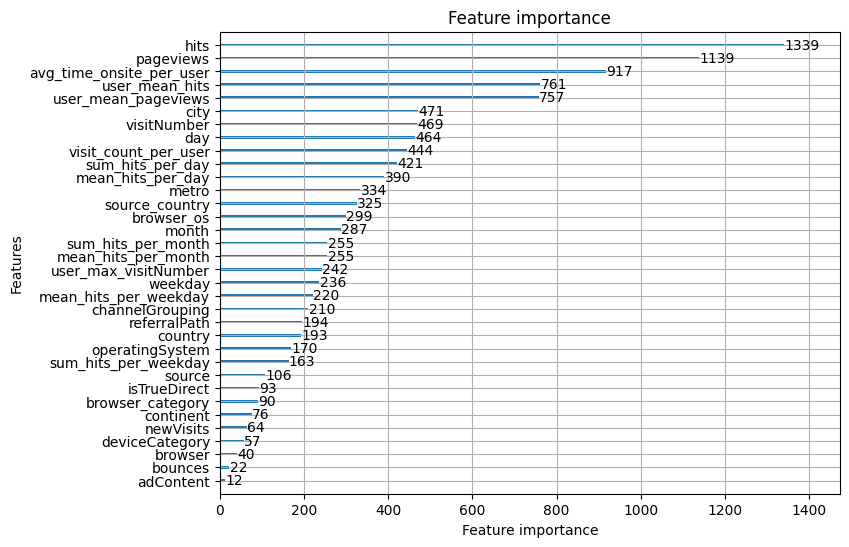

In [67]:
lgb.plot_importance(reg, figsize = (8,6))

Some insights about relative importance of features:

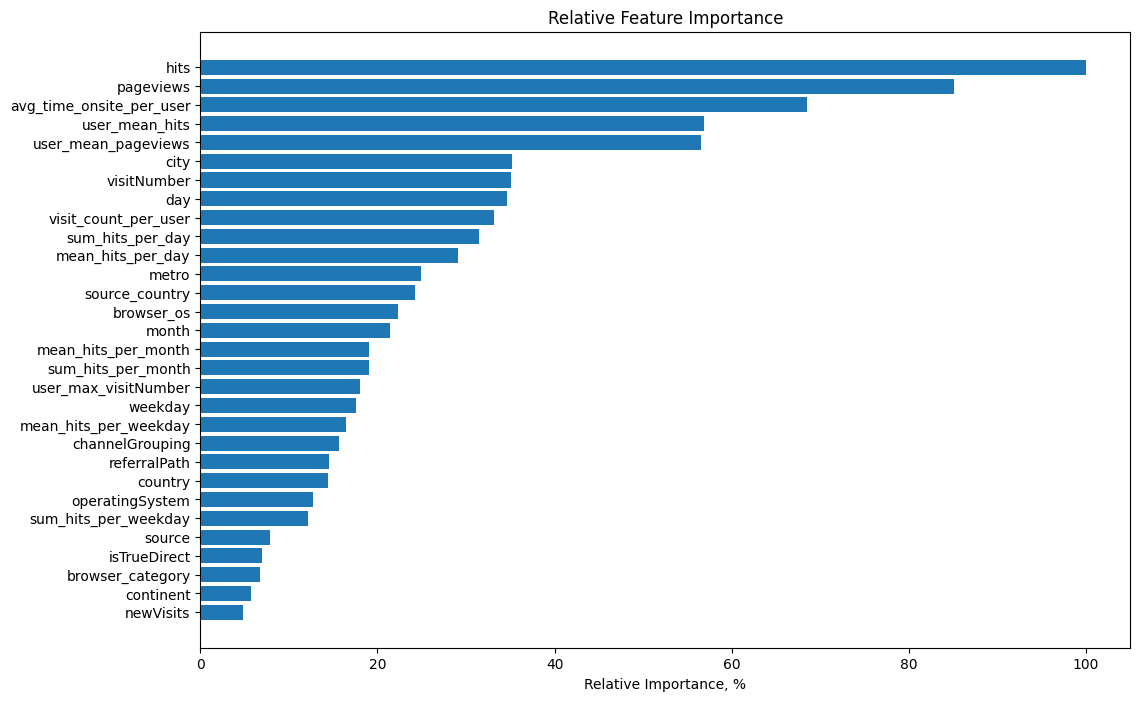

In [70]:
feature_importance = reg.feature_importances_
feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)
sorted_idx = sorted_idx[len(feature_importance) - 30:]
pos = np.arange(sorted_idx.shape[0]) + .5

plt.figure(figsize=(12, 8))
plt.barh(pos, feature_importance[sorted_idx], align = 'center')
plt.yticks(pos, X_train.columns[sorted_idx])
plt.xlabel('Relative Importance, %')
plt.title('Relative Feature Importance')
plt.show()

So, the strongest predictors are:

*hits, pageviews, avg_time_onsite_per_user, user_mean_pageviews, user_mean_hits, visit_count_per_user*.

These variables reflect behavior of users on the platform. On the whole, behavioral variables tend to be strong predictors as they drive useful insights. The correlation between target and the strongest predictors could be noticed on the *heatmap* provided earlier.

Demographic characteristics such as *city, metro* also proved to be quite significant for the model.

What concerns hardware and software (*browser, device category, os*) used by visitor, it doesn't contribute to prediction power of the model significantly. 

The identified relationships are logical and submit to common sense.


<Axes: title={'center': 'Metric during training'}, xlabel='Iterations', ylabel='rmse'>

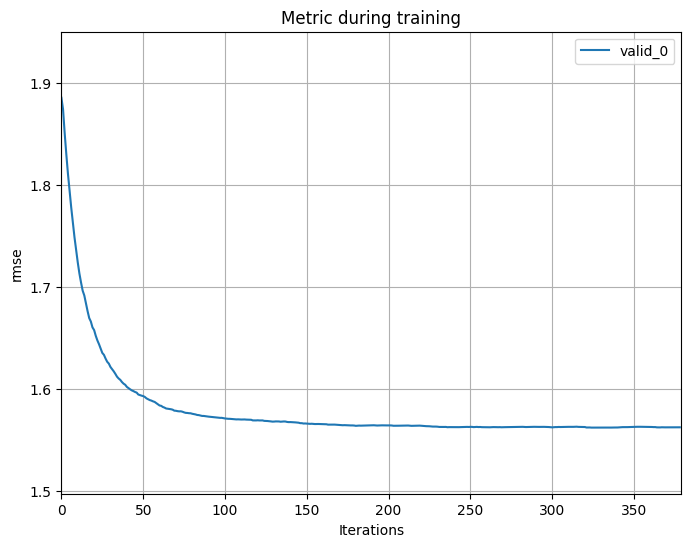

In [71]:
lgb.plot_metric(reg, figsize=(8,6))

The chart provides overview about how the model improved (or how the rmse decreased) over iterations. 